# Manua Loa CO_2 dataset with Recurrent NN Model


In [25]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [26]:
# file path
file_path = "./data/CO2_MaunaLoa2025.csv"

# Load dataset
df = pd.read_csv(file_path)
print(df.head())

   month  decimal date  average  deseasonalized  ndays  sdev   unc
0      3     1958.2027   315.71          314.44     -1 -9.99 -0.99
1      4     1958.2877   317.45          315.16     -1 -9.99 -0.99
2      5     1958.3699   317.51          314.69     -1 -9.99 -0.99
3      6     1958.4548   317.27          315.15     -1 -9.99 -0.99
4      7     1958.5370   315.87          315.20     -1 -9.99 -0.99


#### Detrend time series


In [27]:
co2_values = df['average'].values # get the co2 values

# detrend the time series
diff_co2 = co2_values[1:] - co2_values[:-1]

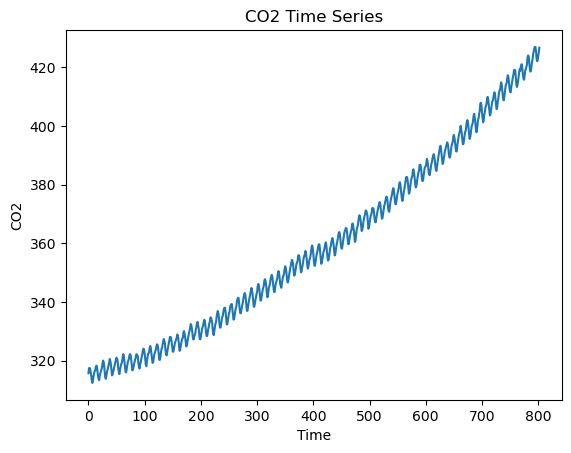

In [28]:
plt.plot(co2_values)
plt.title('CO2 Time Series')
plt.xlabel('Time')
plt.ylabel('CO2')
plt.show()

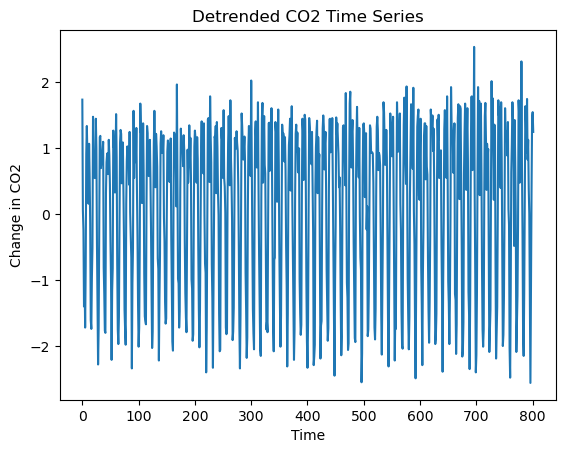

In [29]:
plt.plot(diff_co2)
plt.title('Detrended CO2 Time Series')
plt.xlabel('Time')
plt.ylabel('Change in CO2')
plt.show()

In [30]:
# Prepare supervised learning dataset
def gen_data_splits(data, window_size=1):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

### Window size and label size

In [43]:

window_size = 24  # set window size

forecast = 12

X, y = gen_data_splits(diff_co2, window_size)

# Split into train and test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [32]:
X_train[0]

array([ 1.74,  0.06, -0.24, -1.4 , -0.94, -1.72, -0.79,  0.91,  1.34,
        0.91,  0.91,  0.16,  1.07,  0.57, -0.14, -1.61, -1.74, -0.96,
       -0.51,  1.48,  0.77,  0.85,  0.55,  0.6 ])

### Baseline Models


In [33]:
# Persistence Model
y_pred_persistence = X_test[:, -1]
mse_persistence = mean_squared_error(y_test, y_pred_persistence)
print(f'Persistence Model MSE: {mse_persistence:.4f}')

Persistence Model MSE: 1.1717


In [34]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f'Linear Regression MSE: {mse_lr:.4f}')

Linear Regression MSE: 0.1725


In [35]:
# MLP Model
inp = tf.keras.layers.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(64, activation='relu')(inp)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
out = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(inp, out)
model.summary()
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, 
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

y_pred_mlp = model.predict(X_test, verbose=0).flatten()
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f'MLP Model MSE: {mse_mlp:.4f}')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,769 (18.63 KB)

 Trainable params: 4,769 (18.63 KB)

 Non-trainable params: 0 (0.00 B)

MLP Model MSE: 0.1976


In [36]:
len(y_test)

156

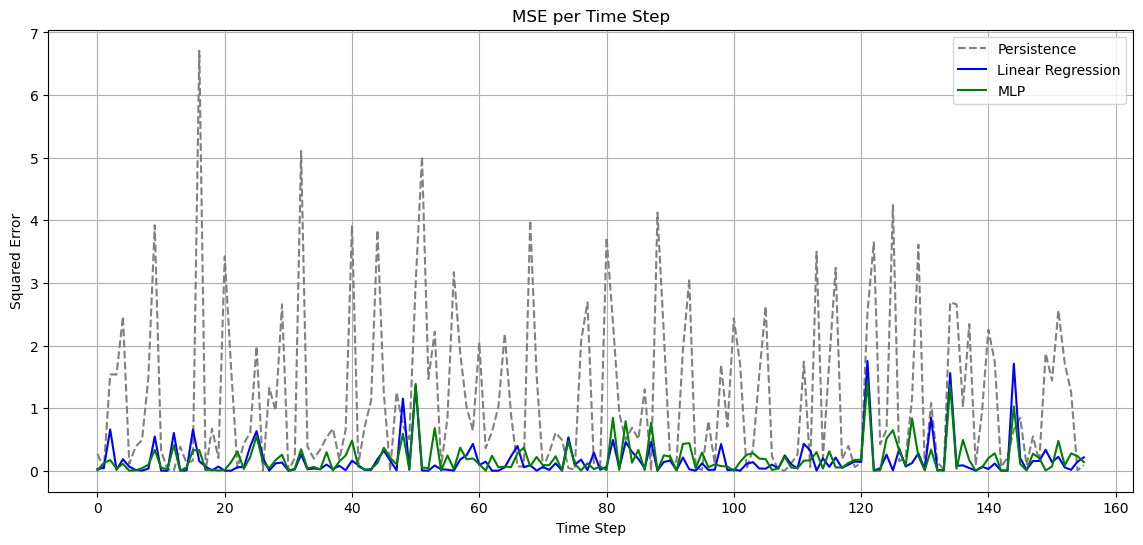

In [37]:
# Compute squared errors for each time step
mse_time_persistence = (y_test - y_pred_persistence) ** 2
mse_time_lr = (y_test - y_pred_lr) ** 2
mse_time_mlp = (y_test - y_pred_mlp) ** 2

# Plot MSE per Time Step
plt.figure(figsize=(14, 6))
time_steps = np.arange(len(y_test))

plt.plot(time_steps, mse_time_persistence, label='Persistence', linestyle='--', color='gray')
plt.plot(time_steps, mse_time_lr, label='Linear Regression', linestyle='-', color='blue')
plt.plot(time_steps, mse_time_mlp, label='MLP', linestyle='-', color='green')

plt.xlabel('Time Step')
plt.ylabel('Squared Error')
plt.title('MSE per Time Step')
plt.legend()
plt.grid(True)
plt.show()

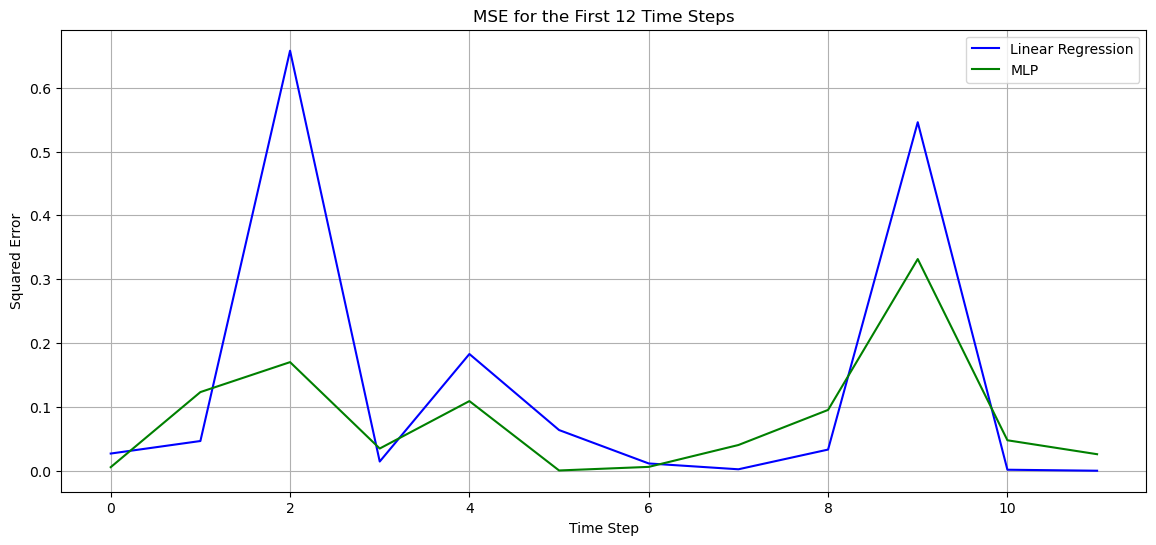

In [38]:
# Slice the last 12 time steps
time_steps_window = time_steps[:forecast]
mse_persistence_window = mse_time_persistence[:forecast]
mse_lr_window = mse_time_lr[:forecast]
mse_mlp_window = mse_time_mlp[:forecast]

# Plot the last 12 time steps
plt.figure(figsize=(14, 6))

# plt.plot(time_steps_window, mse_persistence_window, label='Persistence', linestyle='--', color='gray')
plt.plot(time_steps_window, mse_lr_window, label='Linear Regression', linestyle='-', color='blue')
plt.plot(time_steps_window, mse_mlp_window, label='MLP', linestyle='-', color='green')

plt.xlabel('Time Step')
plt.ylabel('Squared Error')
plt.title('MSE for the First 12 Time Steps')
plt.legend()
plt.grid(True)
plt.show()

## Recurrent Neural Networks


#### LSTM dense encoder


In [48]:
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) # reshape to tensor object 
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)) # reshape to tensor object 

inp = tf.keras.layers.Input(shape=(window_size, 1))
b = tf.keras.layers.LSTM(16, return_sequences=True)(inp) # return sequences to pass the output to the next layer
b = tf.keras.layers.LSTM(16)(b)
out = tf.keras.layers.Dense(1)(b)
out = tf.keras.layers.Lambda(lambda x: x[:, -1])(out) # take the last output


model = tf.keras.models.Model(inp, out)
model.summary()
model.compile(optimizer='adam', loss='mse')

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 16)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281 (12.82 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
X_train_rnn[0]

array([[ 1.74],
       [ 0.06],
       [-0.24],
       [-1.4 ],
       [-0.94],
       [-1.72],
       [-0.79],
       [ 0.91],
       [ 1.34],
       [ 0.91],
       [ 0.91],
       [ 0.16],
       [ 1.07],
       [ 0.57],
       [-0.14],
       [-1.61],
       [-1.74],
       [-0.96],
       [-0.51],
       [ 1.48],
       [ 0.77],
       [ 0.85],
       [ 0.55],
       [ 0.6 ]])

In [46]:
X_train[np.random.randint(0, len(X_train), 10)]

array([[-2.49, -1.04,  0.17,  1.33,  1.49,  1.59,  0.28,  0.22,  1.05,
         1.45, -0.79, -1.38, -2.29, -0.91, -0.19,  1.19,  1.38,  1.38,
         0.53,  1.34,  0.72,  0.6 , -0.66, -1.46],
       [-2.05, -2.15,  0.27,  1.45,  1.69,  0.48,  0.94,  1.49,  0.75,
         0.62, -0.63, -1.75, -1.64, -1.79, -0.12,  1.38,  1.39,  0.66,
         0.7 ,  0.77,  1.61,  0.66, -0.54, -1.73],
       [ 1.23,  0.55,  1.58,  0.55,  0.42,  0.02, -1.72, -1.82, -1.75,
         0.27,  1.08,  1.49,  1.09,  0.44,  1.73,  0.86,  0.52, -0.09,
        -1.91, -1.78, -1.42, -0.11,  1.16,  0.99],
       [ 1.24,  1.21,  0.76,  0.86,  0.12,  1.97,  0.35, -0.98, -1.05,
        -1.72, -1.48,  0.36,  1.3 ,  1.05,  1.  ,  1.02,  0.73,  1.2 ,
         0.98, -0.41, -1.2 , -1.56, -1.79, -0.33],
       [ 0.81, -0.89, -1.46, -2.18, -1.87,  0.04,  1.03,  1.34,  0.79,
         1.22,  0.58,  2.03,  0.74, -0.38, -1.44, -1.81, -2.05,  0.07,
         1.26,  1.41,  1.01,  0.71,  0.76,  1.7 ],
       [ 1.32,  1.35,  0.85,  0.97,

In [50]:
model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

y_pred_lstm_dense_encoder = model.predict(X_test_rnn, verbose=0).flatten()
mse_lstm_dense_encoder = mean_squared_error(y_test, y_pred_lstm_dense_encoder)
print(f'LSTM dense encoder Model MSE: {mse_lstm_dense_encoder:.4f}')

LSTM dense encoder Model MSE: 0.1943


#### LSTM one-shot


#### LSTM iterative


#### LSTM decoder-encoder


In [38]:
# Step (c): Recurrent Neural Networks (RNN, LSTM, GRU)
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

def build_rnn_model(cell_type='SimpleRNN', units=50):
    model = tf.keras.models.Sequential()
    if cell_type == 'SimpleRNN':
        model.add(tf.keras.layers.SimpleRNN(units, input_shape=(window_size, 1)))
    elif cell_type == 'LSTM':
        model.add(tf.keras.layers.LSTM(units, input_shape=(window_size, 1)))
    elif cell_type == 'GRU':
        model.add(tf.keras.layers.GRU(units, input_shape=(window_size, 1)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
    return model

for cell in ['SimpleRNN', 'LSTM', 'GRU']:
    model = build_rnn_model(cell)
    model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, verbose=0)
    y_pred_rnn = model.predict(X_test_rnn)
    mse_rnn = mean_squared_error(y_test, y_pred_rnn)
    print(f'{cell} Model MSE: {mse_rnn:.4f}')

/opt/homebrew/Caskroom/miniconda/base/envs/deep12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
SimpleRNN Model MSE: 0.1804


/opt/homebrew/Caskroom/miniconda/base/envs/deep12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
LSTM Model MSE: 0.1924


/opt/homebrew/Caskroom/miniconda/base/envs/deep12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
GRU Model MSE: 0.1826
